## Hello everybody 😃 😃 welcome back


In [1]:
import os
import cv2 
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Image Size
IMG_ROWS, IMG_COLS = 64, 64 # input image dimensions
NB_CLASSES =  4 # number of outputs = number of digits

## (01)   ACQUISITION DES DONNEES - IMAGES DES FEUILLES DES PLANTES. 

In [2]:
########################################### function for plotting images

def plot_images(images, total_images=100, rows=20, cols=5, fsize=(20,100), titre='Image'):
    
    fig = plt.figure(figsize=fsize) # create a new figure window
    
    for i in range(total_images): # display images
        # subplot : 33 rows and 5 columns
        img_grid = fig.add_subplot(rows, cols, i+1)
        # plot features as image
        img_grid.imshow(images[i])
        
        plt.title(titre)


In [3]:
############################################ function for resizng images
       
def preprocess_image(image, image_height=IMG_ROWS, image_width=IMG_COLS):

    return cv2.resize(image, (image_height, image_width))

############################################ function for reading images 
       
def read_images (path , sz= None ):
    
    print('\nCHARGEMENT DES IMAGES DE LA BASE .......................!\n') 

    X,y = [], []
    
    for dirname , dirnames , filenames in os.walk(path):
        
        c = 0
        
        for subdirname in dirnames :
            
            subject_path = os. path . join ( dirname , subdirname )
            
            for filename in os. listdir ( subject_path ):
                
                im = Image.open(os.path.join(subject_path, filename))
                #im = im.convert ("L")

                if (sz is not None ):
                    im = im.resize (sz , Image.ANTIALIAS ) 
                    
                im = np.array(im)
                im = preprocess_image(im, IMG_ROWS, IMG_COLS)
                X.append(im)
                y.append (c)  
                
            c = c+1
            
    return [X,y]




LECTURE DES IMAGES DE LA BASE D'APPRENTISSAGE........!

CHARGEMENT DES IMAGES DE LA BASE .......................!


AFFICHAGE DE QUELQUES IMAGES DE LA BASE.................!


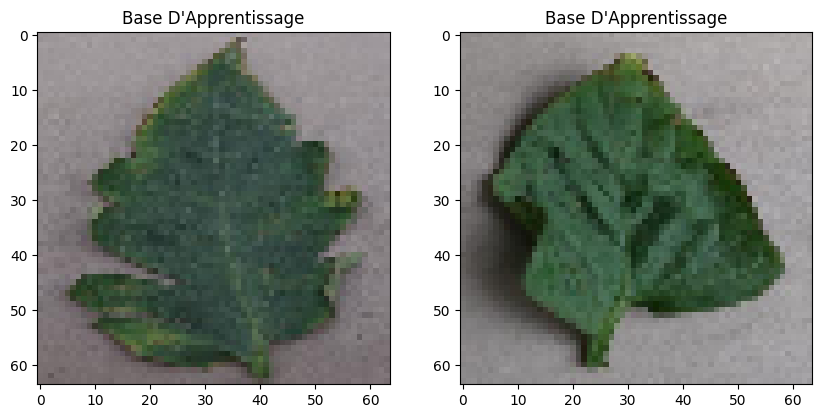


FIN D'AFFICHAGE DES IMAGES DE LA BASE...................!



In [4]:
############################################ Read And Resize test images

print('\n\nLECTURE DES IMAGES DE LA BASE D\'APPRENTISSAGE........!') 

[X_train, y_train] = read_images("C:/Users/Dell 7280/Documents/Etude/ESCEP/S3/Deep learning/Corrections/TP4-Tomato/Data/TrainData") # Potato

print('\nAFFICHAGE DE QUELQUES IMAGES DE LA BASE.................!')
plot_images(X_train, 2, 1, 2,(10, 50), titre='Base D\'Apprentissage')
plt.show()
print('\nFIN D\'AFFICHAGE DES IMAGES DE LA BASE...................!\n')

In [5]:
############################################################# Train Data

# Train Data
images_train = np.asarray(X_train)

# Train targets
train_features = images_train
train_targets = np.asarray(y_train)

NB_CLASSES = np.max(train_targets) + 1

# Vérifiez les valeurs uniques dans train_targets
unique_classes = np.unique(train_targets)
print(f"Unique classes in train_targets: {unique_classes}")

# Vérifiez que les valeurs d'index ne dépassent pas NB_CLASSES
if np.any(train_targets >= NB_CLASSES):
    raise ValueError(f"Certaines étiquettes dans train_targets sont supérieures ou égales à NB_CLASSES={NB_CLASSES}")

# Convertir les vecteurs de classe en matrices de classe binaires
train_targets = to_categorical(train_targets, NB_CLASSES)

print('\nNORMALISATION DES BASES DE TEST ET D\'APPRENTISSAGE.\n')

Unique classes in train_targets: [0 1 2 3 4 5 6 7 8 9]

NORMALISATION DES BASES DE TEST ET D'APPRENTISSAGE.



In [6]:
########################################################## Normalisation

train_features = train_features.astype('float32')

mean_vals = np.mean(train_features, axis=0)
std_val = np.std(train_features)
train_features = (train_features - mean_vals)/std_val

train_features = train_features.reshape(train_features.shape[0], IMG_ROWS, IMG_COLS, 3)
print("train_features.shape     >==============<> : {}".format(train_features.shape))
print("train_targets.shape      >==============<> : {}".format(train_targets.shape))


train_features.shape     >==============<> : (7416, 64, 64, 3)
train_targets.shape      >==============<> : (7416, 10)


In [7]:
########################################################################
#(02)        CLASSIFICATION : CREATION DU MODELE DE PREDICTION         #
########################################################################

In [8]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dropout
from keras.layers import add, Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.optimizers import Adam
import time
from keras.initializers import HeNormal
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [9]:
# Fonction définissant un bloc ResNet
def resnet_block(input_tensor, filters, kernel_size=3, stride=1, dropout_rate=0.3):
    # Première convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same', kernel_initializer=HeNormal())(input_tensor)
    # Normalisation par lot
    x = BatchNormalization()(x)
    # Activation ReLU
    x = Activation('relu')(x)
    x = Dropout(dropout_rate)(x) 
    
    # Activation ReLU
    x = Conv2D(filters, kernel_size=kernel_size, padding='same', kernel_initializer=HeNormal())(x)
    x = BatchNormalization()(x)
    
    # Si le stride n'est pas égal à 1, ajuster l'input_tensor pour correspondre à la dimension de sortie
    if stride != 1:
        input_tensor = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer=HeNormal())(input_tensor)
        input_tensor = BatchNormalization()(input_tensor)
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same', kernel_initializer=HeNormal())(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    
    # Add ResNet blocks
    for _ in range(3):
        x = resnet_block(x, 64)
    for _ in range(4):
        x = resnet_block(x, 128, stride=2 if _ == 0 else 1)
    for _ in range(6):
        x = resnet_block(x, 256, stride=2 if _ == 0 else 1)
    for _ in range(3):
        x = resnet_block(x, 512, stride=2 if _ == 0 else 1)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add Dropout before the output layer
    outputs = Dense(classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model


In [10]:
# Définition de l'optimiseur et des paramètres
OPTIMIZER = Adam()
IMG_ROWS, IMG_COLS = 64, 64  # Mettez les dimensions correctes de vos images ici
INPUT_SHAPE = (IMG_ROWS, IMG_COLS, 3)
NB_CLASSES = 10  # Changez ceci selon votre nombre de classes
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

# Redimensionnement des données d'entrée
def resize_images(images, target_size):
    resized_images = np.zeros((images.shape[0], *target_size, 3))
    for i, img in enumerate(images):
        resized_images[i] = np.resize(img, (*target_size, 3))
    return resized_images

# Charger et redimensionner les images d'entraînement
train_features = resize_images(np.asarray(X_train), (IMG_ROWS, IMG_COLS))

# Convertir les étiquettes en matrices de classe binaires
train_targets = to_categorical(np.asarray(y_train), NB_CLASSES)

print('\nNORMALISATION DES BASES DE TEST ET D\'APPRENTISSAGE.\n')

# Normalisation des données
train_features = train_features.astype('float32')
mean_vals = np.mean(train_features, axis=0)
std_val = np.std(train_features)
train_features = (train_features - mean_vals) / std_val

# Vérifiez les dimensions des données
print("train_features.shape     >==============<> : {}".format(train_features.shape))
print("train_targets.shape      >==============<> : {}".format(train_targets.shape))

def build_resnet(input_shape, classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=2, strides=2, padding='same')(x)
    # Ajoutez les couches supplémentaires pour votre modèle ResNet ici

    x = GlobalAveragePooling2D()(x)
    outputs = Dense(classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Construction et compilation du modèle ResNet
model = build_resnet(input_shape=INPUT_SHAPE, classes=NB_CLASSES)
model.compile(optimizer=OPTIMIZER, loss='categorical_crossentropy', metrics=['accuracy'])

# Affichage du résumé du modèle
model.summary()

# Enregistrement du temps de début d'entraînement
t_start = time.time()

# Entraînement du modèle
history = model.fit(train_features, train_targets, batch_size=BATCH_SIZE, epochs=NB_EPOCH, verbose=VERBOSE)

# Calcul du temps total d'entraînement
time_full_train = time.time() - t_start

# Affichage du temps d'entraînement
print("\nTEMPS D'APPRENTISSAGE DU CLASSIFIEUR >====<> : %0.2fs " % (time_full_train))

# Sauvegarde du modèle entraîné
model.save("ResNet_model_groupe_2.h5")
print('\nENREGISTRER LE MODELE .\n')



NORMALISATION DES BASES DE TEST ET D'APPRENTISSAGE.

train_features.shape     >==============<> : (7416, 64, 64, 3)
train_targets.shape      >==============<> : (7416, 10)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 16, 16, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,378 (40.54 KB)

 Trainable params: 10,250 (40.04 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 20s 143ms/step - accuracy: 0.2937 - loss: 1.9678
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 220ms/step - accuracy: 0.4149 - loss: 1.7134
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 41s 215ms/step - accuracy: 0.4644 - loss: 1.6059
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 220ms/step - accuracy: 0.4789 - loss: 1.5394
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 26s 220ms/step - accuracy: 0.4837 - loss: 1.4818
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 209ms/step - accuracy: 0.5074 - loss: 1.4230
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 43s 219ms/step - accuracy: 0.5234 - loss: 1.3739
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 25s 217ms/step - accuracy: 0.5293 - loss: 1.3481
Epoch 9/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 43s 221ms/step - accuracy: 0.5410 - loss: 1.3193
Epoch 10/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 43s 242ms/step - accuracy: 0.5540 - loss: 1.2758
Epoch 11/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 37s 198ms/step - accuracy: 0.5553 - loss: 1.2717
Epoch 12


TEMPS D'APPRENTISSAGE DU CLASSIFIEUR >====<> : 2255.30s 

ENREGISTRER LE MODELE .



# Measure of AlexNet for one dataset patato
1.  83.02%
2.  89.26%
3.  88.95%
4.  84.88%
5.  84.88%
6.  84.42%
7.  83.26%
8.  84.42%
9.  89.79%
10. 83.49%
Result of AlexNet for ten test = 84.90 %